In [1]:
import jax
import cupy

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
jax.devices()

[CpuDevice(id=0)]

In [3]:
import nifty_ls

CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

In [4]:
import sys

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import astropy.units as u

import h5py 
import matplotlib.pyplot as plt
import scipy.optimize

# from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
# from mpl_axes_aligner import align

import os
import jabble.physics

import jax.config

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


<h1>02 - Fitting RVs to HARPS e2ds Spectra</h1>
In this notebook, I am will show you how to load in data and metadata to jabble.data objects. Then fit models to each component of the data. Due to some edge errors with normalizing near the edge of the orders in the HARPS spectrograph, we fit a longer wavelength component normalization model.

Create output directory here as the current date.

In [5]:
import os
import datetime

today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [6]:
file_b = h5py.File("../data/barnards_e2ds.hdf5", "r")
# file_p = h5py.File("../data/51peg_e2ds.hdf5"   , "r")

In [7]:
jax.print_environment_info()

jax:    0.4.23
jaxlib: 0.4.23
numpy:  1.24.3
python: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


<h2>Jabble.Dataset</h2>
The 4 fields needed to create a jabble.data object are: xs, ys, yivar, and mask. xs is the input to whats being modeled, this should be a list of 1 dimensional jax.numpy arrays, which may have different shapes (lengths). These correspond to the log wavelength values being evaluated. The logarithm of wavelength means that the redshift from relative radial velocity change becomes an additive property.

$$x_{obs} = \log(\lambda_{obs})$$
$$\lambda_{obs} = \sqrt{\frac{1 + RV/c}{1- RV/c}}\lambda_{emit}$$
$$x_{obs} = \log(\sqrt{\frac{1 + RV/c}{1- RV/c}}\lambda_{emit})$$
$$x_{obs} = \log(\sqrt{\frac{1 + RV/c}{1- RV/c}}) + \log(\lambda_{emit})$$
$$x_{obs} = \delta x + x_{emit}$$

where $x_{obs}$ is the observed log wavelength, $RV$ is the radial velocity, $c$ is the speed of light, and $x_{emit}$ is the emitted log wavelength. ys is the measured log flux at that log wavelength, xs. This value is assumed to be in photon per wavelength bin. Thus, multiplicative properties like absorption from tellurics become additive in the logarithm. 

$$y = \log(f)$$
$$y = \log(f_s f_t) $$
$$y = \log(f_s) + \log(f_t) $$
$$y = y_s + y_t$$

yivar stands for y inverse variance, or y information. This value is produced by the instrumentation team at these detectors using some assumption about instrument readout and dark current properties along with poisson photon noise. Thus the error on the flux is not being modeled here and is assumed as correct from the pipeline. These errors are given as the standard deviation of the flux, so we need to transform error of f into the error in logarithm of flux.

$$\sigma_y = \sigma_f \frac{dy}{df}$$
$$\sigma_y = \frac{\sigma_f}{f}$$

In [8]:
def get_dataset(file,orders,device):
    ys = []
    xs = []
    yivar = []
    mask = []

    init_shifts = np.array([jabble.physics.shifts(x) for x in file["bervs"]])
    times_t = np.array([x for x in file["dates"]])
    full_init_shifts = []
    print(file["bervs"].shape)
    airmass = []
    order_out = []
    times = []
    star_ids = []

    for iii in orders:
        for jjj in range(file["data"].shape[1]):
            ys.append(jnp.array(file["data"][iii,jjj,:]))
            xs.append(jnp.array(file["xs"][iii,jjj,:]))
            yivar.append(jnp.array(file["ivars"][iii,jjj,:]))
            mask.append(jnp.zeros(file["data"][iii,jjj,:].shape,dtype=bool))

            # init_shifts.append(
            airmass.append(file["airms"][jjj])
            order_out.append(iii)
            times.append(file["dates"][jjj])
            star_ids.append(str(file))

            full_init_shifts.append(jabble.physics.shifts(file["bervs"][jjj]))
    
    full_init_shifts = jnp.array(full_init_shifts)
    airmass = jnp.array(airmass)

    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)

    dataset.metakeys['times'] = times_t
    dataset.metadata['times'] = np.array(times)
    dataset.metadata['orders'] = np.array(order_out)
    dataset.metadata['star_ids'] = np.array(star_ids)
    dataset.metadata['init_shifts'] = np.array(full_init_shifts)
    dataset.to_device(device)
    
    init_shifts = jax.device_put(init_shifts,device)
    airmass = jax.device_put(airmass,device)
    
    return dataset, init_shifts, airmass, full_init_shifts, times_t

<h2>Jabble.Model</h2>
Now, we will define the components of the model. These stars will have 3 components: stellar, telluric, pseudo-normalization. 

$$y = y_\mathrm{s} + y_\mathrm{t} + y_\mathrm{N}$$

The stellar component will be be high resolution (twice R of the detector) in wavelength and static in flux across all times or epochs of data. However, a nonlinear comes from the redshift radial velocity being fit inside the linear model log flux model. Because our dataset will consist of different orders at the same time, and the same order at different time, and we are assuming the wavelenght solution to be true. Thus the redshift should be the same at different orders at the same time, so $i_*$ is the index of the epoch while $i$ is the data index, which is different for all orders and times or can be thought of simply as the data index.

$$y_s = f(x + \delta x_{i_*}|\theta_\mathrm{s})$$

The tellurics model is also high resolution in wavelength and static across all times, but the airmass is used to stretch the model at each model at each time. This parameter is not fit, however is can be if the user chooses to do so!

$$y_t = a_i f(x|\theta_\mathrm{t})$$

And finally the pseudo-normalization model is low resolution in wavelength about one parameter per 50 Angstroms and is different across all times because we expect the detector state to vary greatly with time.

$$y_\mathrm{N} = f(x|\theta_{\mathrm{N},i})$$

The function we choose to represent the flux of these models is the cardinal spline mixture, who are evenly spaced in wavelength. 

$$f(x|\theta,p) = \sum_i \theta_i k(x|p,i)$$

where $k$ is the cardinal basis/kernel function. This basis function is a piecewise polynomial positioned on an evenly spaced grid such that the total function will be continuous in $p-1$ derivatives.

In [9]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,rest_shifts,airmass,pts_per_wavelength,norm_p_val):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  

    model = jabble.model.CompositeModel(
        [
            jabble.model.EpochShiftingModel(init_shifts),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture_vmap(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts),
            jabble.model.CardinalSplineMixture_vmap(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    ) #+ jabble.model.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

<h2>Training Cycle</h2>
Now we define the fitting process of the parameters of all of these models with respect to the total set of data. This is require some clever initialization, so that we don't end up too far from the solution. First, we fit the parameters of the tellurics, stellar, normalization model. Regularizing the stellar and tellurics components, so that they are close 0. Then we fit the RV alone. Then we optimize everything together with regularization on the stellar and tellurics component.

In [10]:
def train_cycle(model, dataset, loss, lmb, device_store, device_op, batch_size):
    # Fit Stellar & Telluric Template
    model.fix()
    # model.fit(2, 1)
    model.fit(0, 1)
    model.fit(1, 1)
    model.display()
    reg_s = lmb*jabble.loss.L2Reg([0,1])
    reg_t = lmb*jabble.loss.L2Reg([1,1])
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0, 0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # shift_search = jabble.physics.shifts(np.linspace(-10, 10, 100))
    # model[0][0].parabola_fit(shift_search, loss, model, dataset)
    # print(type(model_p[0][0].p))

    # Fit Everything
    model.fix()
    model.fit(0, 0)
    model.fit(0, 1)
    model.fit(1, 1)
    # model.fit(2, 1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size)#model.optimize(loss, dataset)
    print(res1)

    return model

Here we define the 'loss' to be the sum of the chi squared of each flux. This is typical choice when using jabble, and why we must define the inverse variance of y, $I_{y}$ in the data object.

$$\mathcal{L}_{\chi^2} = \sum I_y (y(xs|\delta x_{i_*},\theta_\mathrm{s},\theta_\mathrm{t},\theta_{\mathrm{N},i}) - ys)^2$$

$xs, ys, I_{y}$ are from the data and are then summed over all unmasked elements.

$$\mathcal{L}_{\mathrm{reg}} = \sum \theta_\mathrm{s}^2 + \theta_\mathrm{t}^2$$

$$\mathcal{L}_{total} = \mathcal{L}_{\chi^2} + \lambda \mathcal{L}_{\mathrm{reg}}$$

In [11]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")
loss = jabble.loss.ChiSquare()

Here we define the parameters of the instrument that are needed to build our model. The instrument is HARPS, so the resolution is 115,000. The $p$ value for the CSM model on the stellar and telluric components is set to 2. This means just the first derivative of the model will be continuous. And we will add a wavelength padding to either side of the log wavelength grid out to $100$ km/s in log wavelength. And the lambda for the regularization term is defined here as $\lambda = 100$.

In [12]:
resolution = 115_000
p_val = 2
vel_padding = 100 * u.km / u.s


pts_per_wavelengths = [1/50.0]
norm_p_vals = [3]
lmbs = [100.0]

star_name_b, star_name_p = 'barnards','peg51'

We will not fit the entire spectrum in one pass but we will fit chunks of multiple orders with one RV per epoch.

In [13]:
orders_s = np.arange(0,72,dtype=int).reshape(-1,4) 
print(orders_s)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]
 [48 49 50 51]
 [52 53 54 55]
 [56 57 58 59]
 [60 61 62 63]
 [64 65 66 67]
 [68 69 70 71]]


Also decide what device you want to store extra data on, and which device to put the model and do the fitting on.

In [14]:
import h5py

class Model(jabble.model.Model):
    def save(self,filename: str,mode: str, metadata) -> None:
        with h5py.open(filename,'w') as file:
            self.save_hdf(file)
            self.create_dataset("metadata")
            pass
            

    def save_hdf(self,file):
        group = file.create_group(self.__obj__.__name__)
        group.create_dataset("parameters", data=self.p)
        return group


class ContainerModel(jabble.model.ContainerModel):
    def save_hdf(self,file):
        group = file.create_group(self.__obj__.__name__)
        for model in self.model_list:
            model.save_hdf(self,group)
        return group
        
class LocalCardinalSplineMixture(jabble.model.CardinalSplineMixture_vmap):
    def save_hdf(self,file):
        group = super(LocalCardinalSplineMixture,self).save_hdf(file)
        group.create_dataset("xs",data = self.xs)
        group.create_dataset("alphas", data = self.spline.alphas)
        return group

In [15]:
# device_store = cpus[0]
# device_op = gpus[0]
# batch_size = 5000
    
# for orders in orders_s:
#     for star_name,file in zip([star_name_b],[file_b]):
#         for lmb in lmbs:
#             for norm_p_val in norm_p_vals:
#                 for pts_per_wavelength in pts_per_wavelengths:
        
#                     model_name = os.path.join(out_dir,star_name + '_epoch_inds_o{}_no_norm.mdl'.format(orders))
#                     dataset, init_shifts, airmass, full_init_shifts, times_t = get_dataset(file,orders,device_op)

#                     datablock, metablock, meta_keys = dataset.blockify(device_store,return_keys=True)
                    
#                     shifts = jnp.zeros(full_init_shifts.shape)
#                     model = get_model(dataset,resolution,p_val,vel_padding,-init_shifts,shifts,airmass,pts_per_wavelength,norm_p_val)
                    
#                     for key in dataset.metadata.keys():
#                         model.metadata[key] = dataset.metadata[key]
                    
#                     model.to_device(device_op)
#                     model = train_cycle(model, dataset, loss, lmb, device_store, device_op, batch_size)
#                     jabble.model.save(model_name,model)

In [16]:
import glob

In [17]:
dir = glob.glob('../out/24-12-06/*.mdl')
print(dir)

['../out/24-12-06/barnards_epoch_inds_o[0 1 2 3]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[ 8  9 10 11]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[32 33 34 35]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[16 17 18 19]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[44 45 46 47]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[20 21 22 23]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[56 57 58 59]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[40 41 42 43]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[64 65 66 67]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[48 49 50 51]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[36 37 38 39]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[52 53 54 55]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[60 61 62 63]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[28 29 30 31]_no_norm.mdl', '../out/24-12-06/barnards_epoch_inds_o[68 69 70 71]_no_norm.mdl', '../out/24-12

In [18]:
models = [jabble.model.load(file) for file in dir]

In [19]:
# for model in models:
#     model.fix()
#     model[0][0].fit()
#     model.display()
# models = {"51peg epoch": models[0],\
#           "barns order": models[1],\
#           "barns epoch": models[2],\
#           "51peg order": models[3]}

In [20]:
# lmin = 5680
# lmax = 5690
# lspace = 2

# lrange = np.arange(lmin,lmax+lspace,lspace)

# plt_name= ""
# #'barnards_norm_reg_init_o[5, 6, 7, 8]_p2_w30.000_l100.0.mdl'
# #
# #'barnards_norm_reg_init_o[66, 67, 68, 69]_p4_w100.000_l100.mdl'
# orders = [52]
# rv_inds = [-2,-1,0,2]
# # model_name_b = os.path.join('..','out','24-10-04','barnards_data_inds_o[50, 51, 52]_p3_w50.0_l10.0.mdl')
# # model_name_b = os.path.join('..','out','24-07-02','barnards_all_no_norm.mdl',)
# make_order_plot(file_b,models["barns epoch"],lmin,lmax,lrange,orders,rv_inds,cpus[0])

In [21]:
# rv_data = jabble.physics.velocities(models["barns order"][0][0].p)
# rv_epoch = jabble.physics.velocities(models["barns epoch"][0][0].p)

In [22]:
# orders = np.unique(models["barns order"].metadata['orders'])
# data, _, _, full_init_shifts, _ = get_dataset(file_b,orders,cpus[0])
# datablock, metablock, keys = data.blockify(cpus[0],return_keys=True)

In [23]:
import matplotlib

In [24]:
def rv_comparison_plot(times_d,rv_d,err_d,orders_d,times_e,rv_e,err_e,time_t,targ_vel,targ_err,bervs,bervs_d):
    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )

    # data_indices, epoch_indices, order_indices, star_indices = data.blockify_indices(cpus[0])
    # estimate_vel_2
    
    # print(bervs.shape,np.unique(bervs).shape,estimate_vel.shape)
    # ov = (estimate_vel_d+bervs)
    # ov -= ov.mean()
    cmap = matplotlib.colormaps["viridis"]
    orders_unq = np.unique(orders_d)
    
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(orders))))
    for order in orders_unq:
        indices = np.array([orders_d == order]).squeeze()
        # print(np.sum(indices),indices.shape)
        # ax.errorbar(times_d[indices],rv_d[indices] + bervs,err_d[indices],fmt='.',zorder=1,alpha=0.4,ms=2,label='Order Jabble')

    uni_times = np.unique(times_d)
    ev     = jnp.zeros(len(uni_times))
    evvar = jnp.zeros(len(uni_times))
    info_d = 1/err_d**2
    for iii,time in enumerate(times_e):
        indices = times_d == time
        # print(np.sum(indices))
        # print(np.sum(info_d[indices] < 0.0))
        ev = ev.at[iii].set(jnp.dot(info_d[indices],rv_d[indices])/jnp.sum(info_d[indices]))
        evvar = evvar.at[iii].set((jnp.dot(info_d[indices],rv_d[indices]**2)/jnp.sum(info_d[indices])) - ev[iii]**2)
        # print(evvar[iii],np.mean(1/info_d[indices]))

    ev += bervs
    ev -= ev.mean()
    ax.errorbar(times_e,ev,jnp.sqrt(evvar),fmt='.r',zorder=1,alpha=0.30,ms=2,label='Order Jabble Combined RV')

    rv_order = rv_d + bervs_d
    rv_order -= rv_order.mean()
    ax.errorbar(times_d,rv_order,err_d,fmt='.r',zorder=1,alpha=0.10,ms=2,label='Order Jabble RV')

    correct_vel = targ_vel + bervs
    correct_vel -= correct_vel.mean()
    ax.errorbar(time_t,correct_vel,targ_err,fmt='.k',zorder=3,alpha=0.30,ms=2,label='HARPS RV')
    
    temp_vel = rv_e + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(time_t,temp_vel,err_e,fmt='.b',zorder=2,alpha=0.30,ms=2,label='Epoch Jabble RV')

    
    # fig.legend()
    # ax.set_ylim(-40, 40)
    fig.legend()
    ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD")
    # ax.set_xlim(2.4564e6,2.45644e6)
    # ax.set_ylim(-20e3,-10e3)
    plt.savefig(os.path.join(out_dir, "02-barns_vel_o{}-{}_nobervs_epoch.png".format(np.min(orders),np.max(orders))))
    plt.show()

In [25]:
def rv_targ_zero_plot(times_d,rv_d,err_d,orders_d,times_e,rv_e,err_e,time_t,targ_vel,targ_err,bervs,bervs_d,metadata):
    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )

    # data_indices, epoch_indices, order_indices, star_indices = data.blockify_indices(cpus[0])
    # estimate_vel_2
    
    # print(bervs.shape,np.unique(bervs).shape,estimate_vel.shape)
    # ov = (estimate_vel_d+bervs)
    # ov -= ov.mean()
    cmap = matplotlib.colormaps["viridis"]
    orders_unq = np.unique(orders_d)
    
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(orders))))
    for order in orders_unq:
        indices = np.array([orders_d == order]).squeeze()
        # print(np.sum(indices),indices.shape)
        # ax.errorbar(times_d[indices],rv_d[indices] + bervs,err_d[indices],fmt='.',zorder=1,alpha=0.4,ms=2,label='Order Jabble')

    epoches_span = np.arange(0,len(time_t),dtype=int)
    
    correct_vel = targ_vel + bervs
    correct_vel -= correct_vel.mean()
    ax.errorbar(epoches_span,correct_vel-correct_vel,targ_err,fmt='.-k',zorder=3,alpha=0.30,ms=2,label='HARPS RV')
    
    uni_times = np.unique(times_d)
    ev     = jnp.zeros(len(uni_times))
    evvar = jnp.zeros(len(uni_times))
    info_d = 1/err_d**2
    for iii,time in enumerate(times_e):
        indices = times_d == time
        # print(np.sum(indices))
        # print(np.sum(info_d[indices] < 0.0))
        ev = ev.at[iii].set(jnp.dot(info_d[indices],rv_d[indices])/jnp.sum(info_d[indices]))
        evvar = evvar.at[iii].set((jnp.dot(info_d[indices],rv_d[indices]**2)/jnp.sum(info_d[indices])) - ev[iii]**2)
        # print(evvar[iii],np.mean(1/info_d[indices]))

    ev += bervs
    ev -= ev.mean()
    ax.errorbar(epoches_span,ev - correct_vel,jnp.sqrt(evvar),fmt='.r',zorder=1,alpha=0.30,ms=2,label='Order Jabble Combined RV')

    rv_order = rv_d + bervs_d
    rv_order -= rv_order.mean()
    ax.errorbar(epoches_span[metadata['times']],rv_order - correct_vel[metadata['times']],err_d,fmt='.r',zorder=1,alpha=0.10,ms=2,label='Order Jabble RV')
    
    temp_vel = rv_e + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(epoches_span,temp_vel - correct_vel,err_e,fmt='.b',zorder=2,alpha=0.30,ms=2,label='Epoch Jabble RV')

    
    # fig.legend()
    # ax.set_ylim(-40, 40)
    fig.legend()
    ax.set_title('Barnard\'s Star HARPS Comparison')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "epoch index")
    # ax.set_xlim(2.4564e6,2.45644e6)
    # ax.set_ylim(-20e3,-10e3)
    plt.savefig(os.path.join(out_dir, "02-barns_targ_o{}-{}_nobervs_epoch.png".format(np.min(orders),np.max(orders))))
    plt.show()

In [26]:
# datablock, metablock, keys = dataset.blockify(cpus[0],return_keys=True)

In [27]:
# rv_data = jabble.physics.velocities(models["barns order"][0][0].p)
# err_data = get_verr(models["barns order"][0][0].p,f_info_arr_d)
# rv_epoch = jabble.physics.velocities(models["barns epoch"][0][0].p)
# err_epoch = get_verr(models["barns epoch"][0][0].p,f_info_arr_e)

# rv_comparison_plot(models["barns order"].metadata['times'],rv_data,err_data,models["barns order"].metadata['orders'],\
#                    np.array(file_b['dates']),rv_epoch,err_epoch,\
#                    np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
#                    np.array(file_b['bervs']),np.array(file_b['bervs'])[metablock['times']])
# rv_targ_zero_plot(models["barns order"].metadata['times'],rv_data,err_data,models["barns order"].metadata['orders'],\
#                    np.array(file_b['dates']),rv_epoch,err_epoch,\
#                    np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
#                    np.array(file_b['bervs']),np.array(file_b['bervs'])[metablock['times']],metablock)

In [28]:

# dir = glob.glob('../out/24-12-06/b*.mdl')

In [29]:
file_b.keys()

<KeysViewHDF5 ['airms', 'bervs', 'data', 'dates', 'drifts', 'filelist', 'ivars', 'pipeline_rvs', 'pipeline_sigmas', 'xs']>

In [30]:
def dict_ele(dictionary,ele_i,device):
        out = {}
        for key in dictionary:
            out[key] = jax.device_put(dictionary[key][ele_i],device)
        return out

In [31]:
file_b.keys(),file_b['bervs'].shape

(<KeysViewHDF5 ['airms', 'bervs', 'data', 'dates', 'drifts', 'filelist', 'ivars', 'pipeline_rvs', 'pipeline_sigmas', 'xs']>,
 (306,))

In [32]:
# jabble_file = h5py.File('../out/24-10-23/rv_jabble.hdf5','w')

In [33]:
all_rv = np.zeros((len(dir),*file_b['bervs'].shape))
all_order = np.zeros((len(dir),int(file_b['data'].shape[0]/len(dir))))

all_err = np.zeros((len(dir),*file_b['bervs'].shape))
all_times = np.array(file_b['dates'])
all_models = []

all_loss = np.zeros((len(dir),int(file_b['data'].shape[0]/len(dir)),*file_b['data'].shape[1:]))
for iii,filename in enumerate(dir):

    model = jabble.model.load(filename)
    orders = np.unique(model.metadata['orders'])
    dataset, init_shifts, airmass, full_init_shifts, times_t = get_dataset(file_b,orders,cpus[0])
    datablock, metablock, meta_keys = dataset.blockify(cpus[0],return_keys=True)
    all_order[iii,:] = meta_keys['orders']
    #print(meta_keys)
    for jjj in range(len(dataset)):
        datarow = dict_ele(datablock,jjj,cpus[0])
        metarow = dict_ele(metablock,jjj,cpus[0])
        model.fix()
        #model.display()
        #print(datarow,metarow)
        temp = loss(model.get_parameters(),datarow,metarow,model)
        
        # dataset.metadata['times'][iii]
        all_loss[iii,*np.where(dataset.metadata['orders'][jjj] == meta_keys['orders']),metarow['times'],:] = temp
        
    
    f_info_arr = model[0][0].f_info(model,dataset,loss,cpus[0])
    rv_data = jabble.physics.velocities(model[0][0].p)
    err_data = jabble.physics.get_verr(model[0][0].p,f_info_arr)

    all_rv[iii,:] = rv_data
    all_err[iii,:] = err_data
    all_models.append(model)

(306,)
-AdditiveModel---------------------------------------------------306
  0-CompositeModel-----------------------------------------------306
  0  0-EpochShiftingModel----------------------------------------306
  0  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1  2-StretchingModel---------------------------------------------0


/home/mdd423/wobble_jax/notebooks/../jabble/physics.py:17: RuntimeWarning: divide by zero encountered in divide
  verr = np.sqrt(1 / f_info) * dvddx


(306,)
-AdditiveModel---------------------------------------------------306
  0-CompositeModel-----------------------------------------------306
  0  0-EpochShiftingModel----------------------------------------306
  0  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1  2-StretchingModel---------------------------------------------0
(306,)
-AdditiveModel---------------------------------------------------306
  0-CompositeModel-----------------------------------------------306
  0  0-EpochShiftingModel----------------------------------------306
  0  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel------------------

In [34]:
with h5py.File('../out/24-12-06/barnards_jrv.hdf5','w') as jabble_file:
    jabble_file.create_dataset('RV',data=all_rv)
    jabble_file.create_dataset('RV_err',data=all_err)
    jabble_file.create_dataset('loss',data=all_loss)
    jabble_file.create_dataset('times',data=all_times)
    jabble_file.create_dataset('order',data=all_order)

    rv_comb = np.zeros(file_b['bervs'].shape)
    var_comb = np.zeros(file_b['bervs'].shape)
    info = 1/jabble_file['RV_err'][:,:]**2
    for iii in range(jabble_file['RV'].shape[1]):
        mask_1 = ~np.isnan(info[:,iii])
        mask_2 = info[:,iii] < 1e10
        mask = (mask_1 * mask_2).astype(bool)
        mask = ~np.isnan(info[:,iii])
        rv_comb[iii]  =   jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii] ) / jnp.sum(info[mask,iii])
        var_comb[iii] = ( jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii]**2 ) / jnp.sum(info[mask,iii]) ) - rv_comb[iii]**2
    
    jabble_file.create_dataset('RV_comb',data=rv_comb)
    jabble_file.create_dataset('RV_comb_err',data=np.sqrt(var_comb))

In [35]:
jabble_file =  h5py.File('../out/24-12-06/barnards_jrv.hdf5','r')

In [36]:
# jabble_file =  h5py.File('../out/24-10-23/rv_jabble.hdf5','r')

In [37]:
def rv_all_order_plot(times,rv_e,err_e,rv_comb,err_comb,targ_vel,targ_err,bervs,period=3.1533):
    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    temp_vel = targ_vel + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(times % period,temp_vel,targ_err,fmt='.g',zorder=3,alpha=0.30,ms=2,label='HARPS RV')
    
    temp_vel = rv_comb + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(times % period,temp_vel,err_comb,fmt='.r',zorder=2,alpha=0.60,ms=2,label='Order Jabble Combined RV')

    temp_vel = rv_e.mean(axis=0) + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(times % period,temp_vel,0.0,fmt='.b',zorder=2,alpha=0.60,ms=2,label='Avg RV')

    for i in range(rv_e.shape[0]):
        temp_vel = rv_e[i,:] + bervs
        temp_vel -= temp_vel.mean()
        ax.errorbar(times % period,temp_vel,yerr=err_e[i,:],fmt='.k',zorder=1,alpha=0.05,ms=2,label='Order Jabble RV')

    # fig.legend()
    ax.set_ylim(-200, 200)
    # fig.legend()
    ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD")
    # ax.set_xlim(2.4564e6,2.45644e6)
    # ax.set_ylim(-20e3,-10e3)
    # plt.savefig(os.path.join(out_dir, "02-barns_all_order_nobervs_epoch.png"))
    plt.show()

In [99]:
def rv_all_order_harps_plot(times,rv_e,err_e,rv_comb,err_comb,targ_vel,targ_err,bervs,loss):
    
    epoches_span = np.arange(0,len(times),dtype=int)

    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )

    temp_vel = targ_vel + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(epoches_span,temp_vel,targ_err,fmt='.g',zorder=3,alpha=0.30,ms=2,label='HARPS RV')

    temp_vel = rv_comb + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(epoches_span,temp_vel,err_comb,fmt='.r',zorder=2,alpha=0.60,ms=2,label='Order Jabble Combined RV')

    temp_vel = rv_e.mean(axis=0) + bervs
    temp_vel -= temp_vel.mean()
    ax.errorbar(epoches_span,temp_vel,0.0,fmt='.b',zorder=2,alpha=0.60,ms=2,label='Avg RV')

    for i in range(rv_e.shape[0]):
        temp_vel = rv_e[i,:] + bervs
        temp_vel -= temp_vel.mean()
        ax.errorbar(epoches_span,temp_vel,yerr=err_e[i,:],fmt='.k',zorder=1,alpha=0.05,ms=2,label='Order Jabble RV')

    ax.set_ylim(-200, 200)
    # fig.legend()
    ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "epoch index")
    # ax.set_xlim(2.4564e6,2.45644e6)
    # ax.set_ylim(-20e3,-10e3)
    # plt.savefig(os.path.join(out_dir, "02-barns_all_order_nobervs_epoch.png"))
    plt.show()

    rv_difference_array = np.zeros(rv_e.shape)
    print(rv_comb.shape,rv_e.shape)
    for i in range(rv_e.shape[1]):
        rv_difference_array[:,i] = rv_comb[i] - rv_e[:,i]

    plt.figure(figsize=(12,6),facecolor=(1, 1, 1),dpi=300)
    im = plt.imshow(rv_difference_array,interpolation ='nearest',vmin=-100,vmax=100)
    plt.xlabel('epoches')
    plt.ylabel('chunks')
    plt.title('$\Delta$ RV')
    plt.colorbar(im,shrink=0.3)  
    plt.savefig(os.path.join(out_dir,'drv.png'))
    plt.show()

    
    loss_mean = np.mean(loss,axis=3).mean(axis=1)
    print(loss_mean.shape)

    plt.figure(figsize=(12,6),facecolor=(1, 1, 1),dpi=300)
    im = plt.imshow(loss_mean,interpolation ='nearest',vmin=0,vmax=10)
    plt.xlabel('epoches')
    plt.ylabel('chunks')
    plt.title('$\chi^2$')
    plt.colorbar(im,shrink=0.3)
    plt.savefig(os.path.join(out_dir,'obj.png'))
    plt.show()

In [39]:
jabble_file.keys()
for key in jabble_file.keys():
    print(key,jabble_file[key].shape)

RV (18, 306)
RV_comb (306,)
RV_comb_err (306,)
RV_err (18, 306)
loss (18, 4, 306, 4096)
order (18, 4)
times (306,)


In [40]:
import matplotlib
import matplotlib.colors

In [41]:
# cmap = cm.get_cmap("Spectral")
cmap = matplotlib.colormaps["Spectral"]

In [42]:
def make_order_plot(dataset,model,lrange,orders,rv_inds,device):
    # model = jabble.model.load(model_name)
    data_orders = np.unique(model.metadata["orders"])

    model.fit()
    model.display()
    model.fix()
    
    # for dataframe in dataset:
    #     print(np.exp(np.min(dataset.xs)))
    # model_name_b = os.path.join('..','out','24-06-11','peg51_o{}_no_norm.mdl'.format(order))
    plt_epoches = []
    data, meta, keys = dataset.blockify(device,return_keys=True)
    # print(meta["times"].shape,model[0][0].p.shape)
    temp = np.argsort(model[0][0].p[meta["times"]])
    # which_ones = [0,-1,-2,1]
    # which_ones = jax.random.randint(jax.random.PRNGKey(0), shape=(3,), minval=0, maxval=len(temp), dtype=jnp.uint8)
    # print( np.unique(model.metadata["orders"]) == orders[0])
    for uni_order in orders:
        # print(uni_order)
        for iii in rv_inds:
            # print(temp,temp.dtype,model.metadata["orders"],type(model.metadata["orders"][0]))
            # print(dataset.metadata["orders"],np.sum(dataset.metadata["orders"] == uni_order))
            args_order = temp[np.array(dataset.metadata["orders"])[temp] == uni_order]
            # print(args_order)
            # print(len(temp),len(args_order),uni_order,args_order[iii])
            # plt_epoches.append(temp[uni_order == model.metadata["orders"]][-1])
            plt_epoches.append(int(args_order[iii]))
    # plt_epoches = [0,1,2,3]#[*sorted_epoches[-1:],*sorted_epoches[:1]]
    
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)

    # print(plt_epoches,len(temp))
    model.fix()
    # model.display()
    nothing = model.get_parameters()
    for ii, plt_epoch in enumerate(plt_epoches):
        # indices = model.metadata['times'] == model.metadata['times'][plt_epoch]

        datarow = jabble.loss.dict_ele(data,plt_epoch,device)
        metarow = jabble.loss.dict_ele(meta,plt_epoch,device)

        # print(metarow['index'],plt_epoch)
        
        xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                            dataset.xs[plt_epoch].shape[0]*10)
        # yplot = model[2]([],xplot,plt_epoch)
        yplot_norm_tot  = model([],xplot,metarow)
        yplot_norm_stel = model[0]([],xplot,metarow)
        yplot_norm_tell = model[1]([],xplot,metarow)
        # yplot_norm      = model[2]([],xplot,metarow)
        # for epoch in np.where(indices):
        yhat = model([],dataset.xs[plt_epoch][:],metarow)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())

        velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
        
        # Data
        axes[0,ii].plot(datarow["xs"][:],datarow["ys"][:],\
                                 '.k',zorder=100,alpha=0.1,ms=7)

        # Stellar Model        
        axes[0,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Telluric Model
        axes[0,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Total
        axes[0,ii].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Norm
        # axes[0,ii].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Theory Model
        # theory_ax = axes[0,ii].twinx()
        # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # theory_ax.set_ylim(-5,5)
        # Line List

        # shift_by_eye = (np.log(5002) - np.log(5000))
        # for line in line_list[1].data[(line_list[1].data["Wave"] > lmin) * (line_list[1].data["Wave"] < lmax)]:
        #     print(line["Species"])
            # axes[0,ii].vlines(np.log(line["Wave"]) + model[0][0].p[plt_epoch] + shift_by_eye,-100,len(dataset),'k','dashed',alpha=0.4)
        
        # Residuals
        axes[1,ii].step(dataset.xs[plt_epoch],dataset.ys[plt_epoch] - yhat,\
                                 'k',where='mid',zorder=1,alpha=0.3,ms=3)

        # axes[0,ii].set_title("order $ = {}$".format(model.metadata["orders"][plt_epoch]))
        axes[0,ii].set_ylim(-2.5,0.5)
        # axes[1,ii].set_ylim(-0.08,0.08)
        axes[0,ii].set_xticks([])
        axes[0,ii].set_xticks(np.log(lrange[ii,:]))
        axes[0,ii].set_xticklabels(['{:0.1f}'.format(x) for x in lrange[ii,:]])
        axes[0,ii].set_xlim(np.log(lrange[ii,:].min()),np.log(lrange[ii,:].max()))
        # axes[0,ii].set_xlim([np.log(lmin), np.max(lmax)])

    # plt.x
    # plt.text(1, 1, 'Wavelength ($\AA$)', ha='center')
    # plt_name = os.path.join(out_dir, "02-spectra_{}_{}-{}.png".format(os.path.split(model_name)[-1],lmin,lmax))
    # plt.savefig(plt_name,dpi=200,bbox_inches='tight')
    # fig.suptitle('Barnards Star')
    fig.text(0.5, 0.00, 'Wavelength $[\AA]$', ha='center')
    fig.text(0.08, 0.5, 'Normalized Flux', va='center', rotation='vertical')
    plt.show()

In [44]:
file_b['xs'].shape

(72, 306, 4096)

0.025 stellar radii

$1/0.025$

[20 21 22 23]
(306,)
[[4342. 4346. 4350. 4354. 4358. 4362.]
 [4373. 4377. 4381. 4385. 4389. 4393.]
 [4404. 4408. 4412. 4416. 4420. 4424.]
 [4436. 4440. 4444. 4448. 4452. 4456.]]
-AdditiveModel-------------------------------------------------18096
  0-CompositeModel----------------------------------------------7977
  0  0-EpochShiftingModel----------------------------------------306
  0  1-CardinalSplineMixture_vmap------------------------------------------------7671
  1-CompositeModel---------------------------------------------10119
  1  0-ShiftingModel--------------------------------------------1224
  1  1-CardinalSplineMixture_vmap------------------------------------------------7671
  1  2-StretchingModel------------------------------------------1224


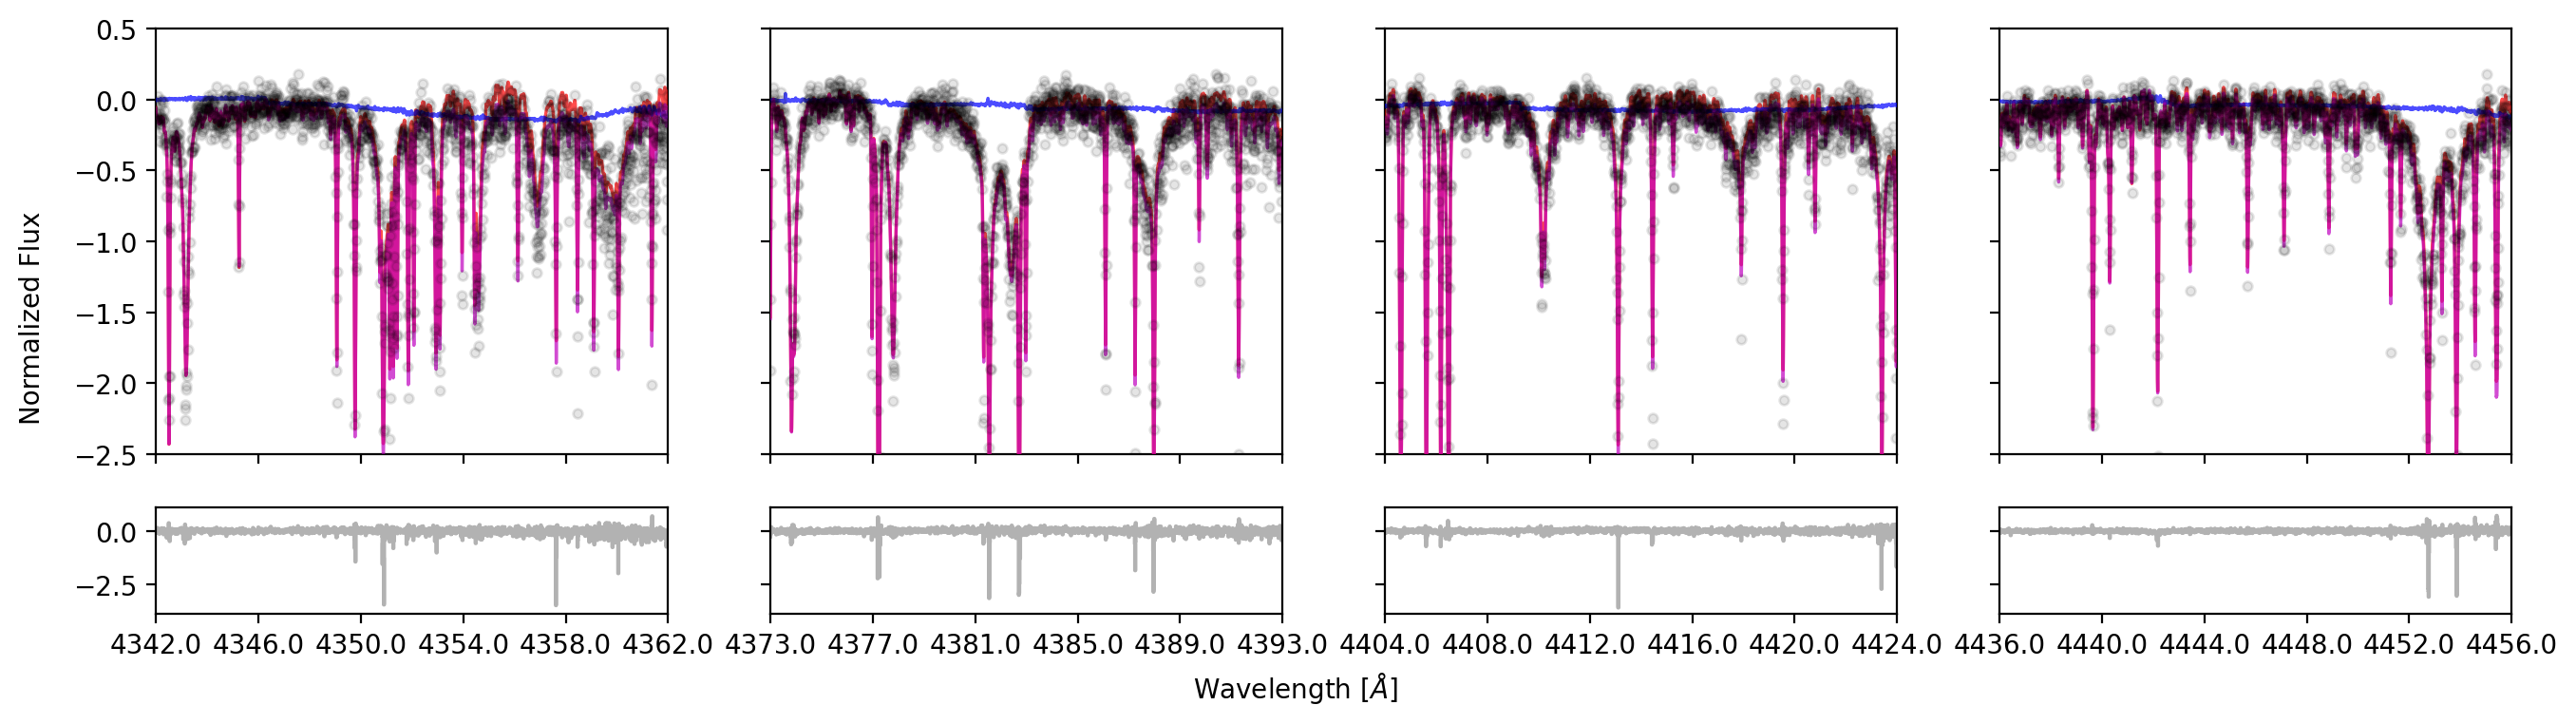

In [94]:
model_index = 5
rv_inds = [0]
# rv_data = jabble.physics.velocities(all_models[jjj][0][0].p)
orders = np.unique(all_models[model_index].metadata['orders'])
print(orders)

dataset, _, _, _, _ = get_dataset(file_b,orders,cpus[0])
ls_means = np.ceil(np.exp(file_b['xs'][orders].mean(axis=1).mean(axis=1)))
lrange = ls_means[:,None] + np.arange(0.0,24.0,4.0)[None,:]
print(lrange)
make_order_plot(dataset,all_models[model_index],lrange,orders,rv_inds,cpus[0])

In [46]:
info = 1/jabble_file['RV_err'][:,:]**2
bervs = np.array(file_b['bervs'])
temp = np.array(jabble_file["loss"]) <= 0
# print(np.sum(temp))
# print(np.array(jabble_file["loss"])[temp])
# print(np.stack(np.where(temp)).T)
loss_temp = np.array(jabble_file["loss"])
loss_temp[temp] = 0.0
print(np.sum(loss_temp <= 0)/np.product(loss_temp.shape))
loss_mean = np.mean(loss_temp,axis=3).mean(axis=1)

looking_ind = np.where(loss_mean <= 0)
print(np.stack(looking_ind).T)
print(loss_mean[looking_ind])

# norm = cmap.LogNorm(np.min(loss_sum),np.max(loss_sum))

for iii in range(jabble_file["RV"].shape[1]):
    mask_1 = ~np.isnan(info[:,iii])
    mask_2 = info[:,iii] < 1e10
    mask = (mask_1 * mask_2).astype(bool)
    rv_comb = jnp.average(jabble_file['RV'][mask,iii],weights=info[mask,iii])
        # rv_comb  =   jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii] ) / jnp.sum(info[mask,iii])
    var_comb = jnp.average((jabble_file['RV'][mask,iii])**2,weights=info[mask,iii]) - rv_comb**2
    # if (np.all(jabble_file["RV"][:,iii]>rv_comb)) or (np.all(jabble_file["RV"][:,iii]<rv_comb)):
    #     if (np.any(info[mask,iii] > 1e10)):
    jjjs, = np.where(info[mask,iii] > 1e10)
    # print(rv_comb,var_comb, np.min(info[:,iii]), np.max(info[:,iii]))
    rv_difference = np.sqrt((rv_comb - jabble_file['RV'][mask,iii])**2)
    print(np.max(rv_difference),np.where(rv_difference == rv_difference.max()))
    jjjs, = np.where(rv_difference == rv_difference.max())
    
    # print(loss_sum[:,iii])
#     # print(jabble_file["RV"][:,iii],"\n", jabble_file["RV_comb"][iii],jabble_file["RV_err"][:,iii])
    
#     mask = ~np.isnan(info[:,iii])
#     rv_comb = jnp.average(jabble_file['RV'][mask,iii] + bervs[iii],weights=info[mask,iii])
#     # rv_comb  =   jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii] ) / jnp.sum(info[mask,iii])
#     var_comb = jnp.average((jabble_file['RV'][mask,iii] + bervs[iii])**2,weights=info[mask,iii]) - rv_comb**2
#     print((np.all(jabble_file["RV"][:,iii]>rv_comb)) or (np.all(jabble_file["RV"][:,iii]<rv_comb)))
#     # print(( jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii]**2 ) / jnp.sum(info[mask,iii]) ) < rv_comb**2)
#     print(rv_comb,var_comb)
    # plt.scatter(jabble_file["RV"][mask,iii],info[mask,iii],alpha=0.4,zorder=1,c=cmap(loss_mean[mask,iii]))
    # plt.scatter([rv_comb],[1/var_comb],alpha=0.8,zorder=2,c='blue')
    # plt.colorbar()
    # plt.xlabel("RV")
    # plt.ylabel("RV Info")
    # plt.yscale("log")
    # plt.show()

    # for jjj in jjjs:
    #     print(jjj)
    #     rv_data = jabble.physics.velocities(all_models[jjj][0][0].p)
    #     orders = np.unique(all_models[jjj].metadata['orders'])
    #     lmean = np.mean(np.exp(all_models[jjj][0][1].xs))
    #     lmin = lmean-10
    #     lmax = lmean+10
    #     lspace = 4
        
    #     lrange = np.arange(lmin,lmax+lspace,lspace)
        
    #     rv_inds = [-1,0,1]
    #     make_order_plot(file_b,all_models[jjj],lmin,lmax,lrange,[orders[1]],rv_inds,cpus[0])
# #     # print(np.sum(np.isnan(info[:,iii])))
#     # if (np.any(jabble_file["RV_err"][:,iii]<0)):
#     #     print(jabble_file["RV"][:,iii],"\n", jabble_file["RV_comb"][iii],jabble_file["RV_err"][:,iii])
#     #     mask = ~np.isnan(info[:,iii])
    #     rv_comb  =   jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii] ) / jnp.sum(info[mask,iii])
    #     var_comb = ( jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii]**2 ) / jnp.sum(info[mask,iii]) ) - rv_comb**2
    #     print(( jnp.dot( info[mask,iii],jabble_file['RV'][mask,iii]**2 ) / jnp.sum(info[mask,iii]) ) < rv_comb**2)
    #     print(rv_comb,np.sqrt(var_comb))

0.1390323902094113
[[  0 211]]
[0.]
71.76647440934175 (array([0]),)
1353.2027886168835 (array([5]),)
196.33273856278902 (array([0]),)
844.0356480595801 (array([15]),)
145.5069657226395 (array([15]),)
659.6090821064572 (array([0]),)
693.5513045466796 (array([15]),)
243.89968156463146 (array([0]),)
408.960910386515 (array([3]),)
91.4372151726784 (array([0]),)
366.226292969468 (array([15]),)
81.20117689022663 (array([3]),)
253.9632358244853 (array([16]),)
1413.513008662032 (array([0]),)
295.9298220292876 (array([0]),)
643.3741116637193 (array([15]),)
313.52171631201054 (array([0]),)
51.06002927237569 (array([15]),)
103.55676073587165 (array([15]),)
576.8526196233506 (array([15]),)
542.4292760604003 (array([15]),)
96.22531904031348 (array([0]),)
97.71146329322801 (array([0]),)
604.4740447956647 (array([0]),)
197.27677641585615 (array([15]),)
336.98345141660866 (array([0]),)
532.4183696082819 (array([15]),)
602.1839482832474 (array([0]),)
135.1867652616529 (array([0]),)
475.53867245525 (arr

In [90]:
np.average(np.array(jabble_file['RV_comb_err'])), np.average(np.array(file_b['pipeline_sigmas']))

(4.375217326060549, 0.8133012466462529)

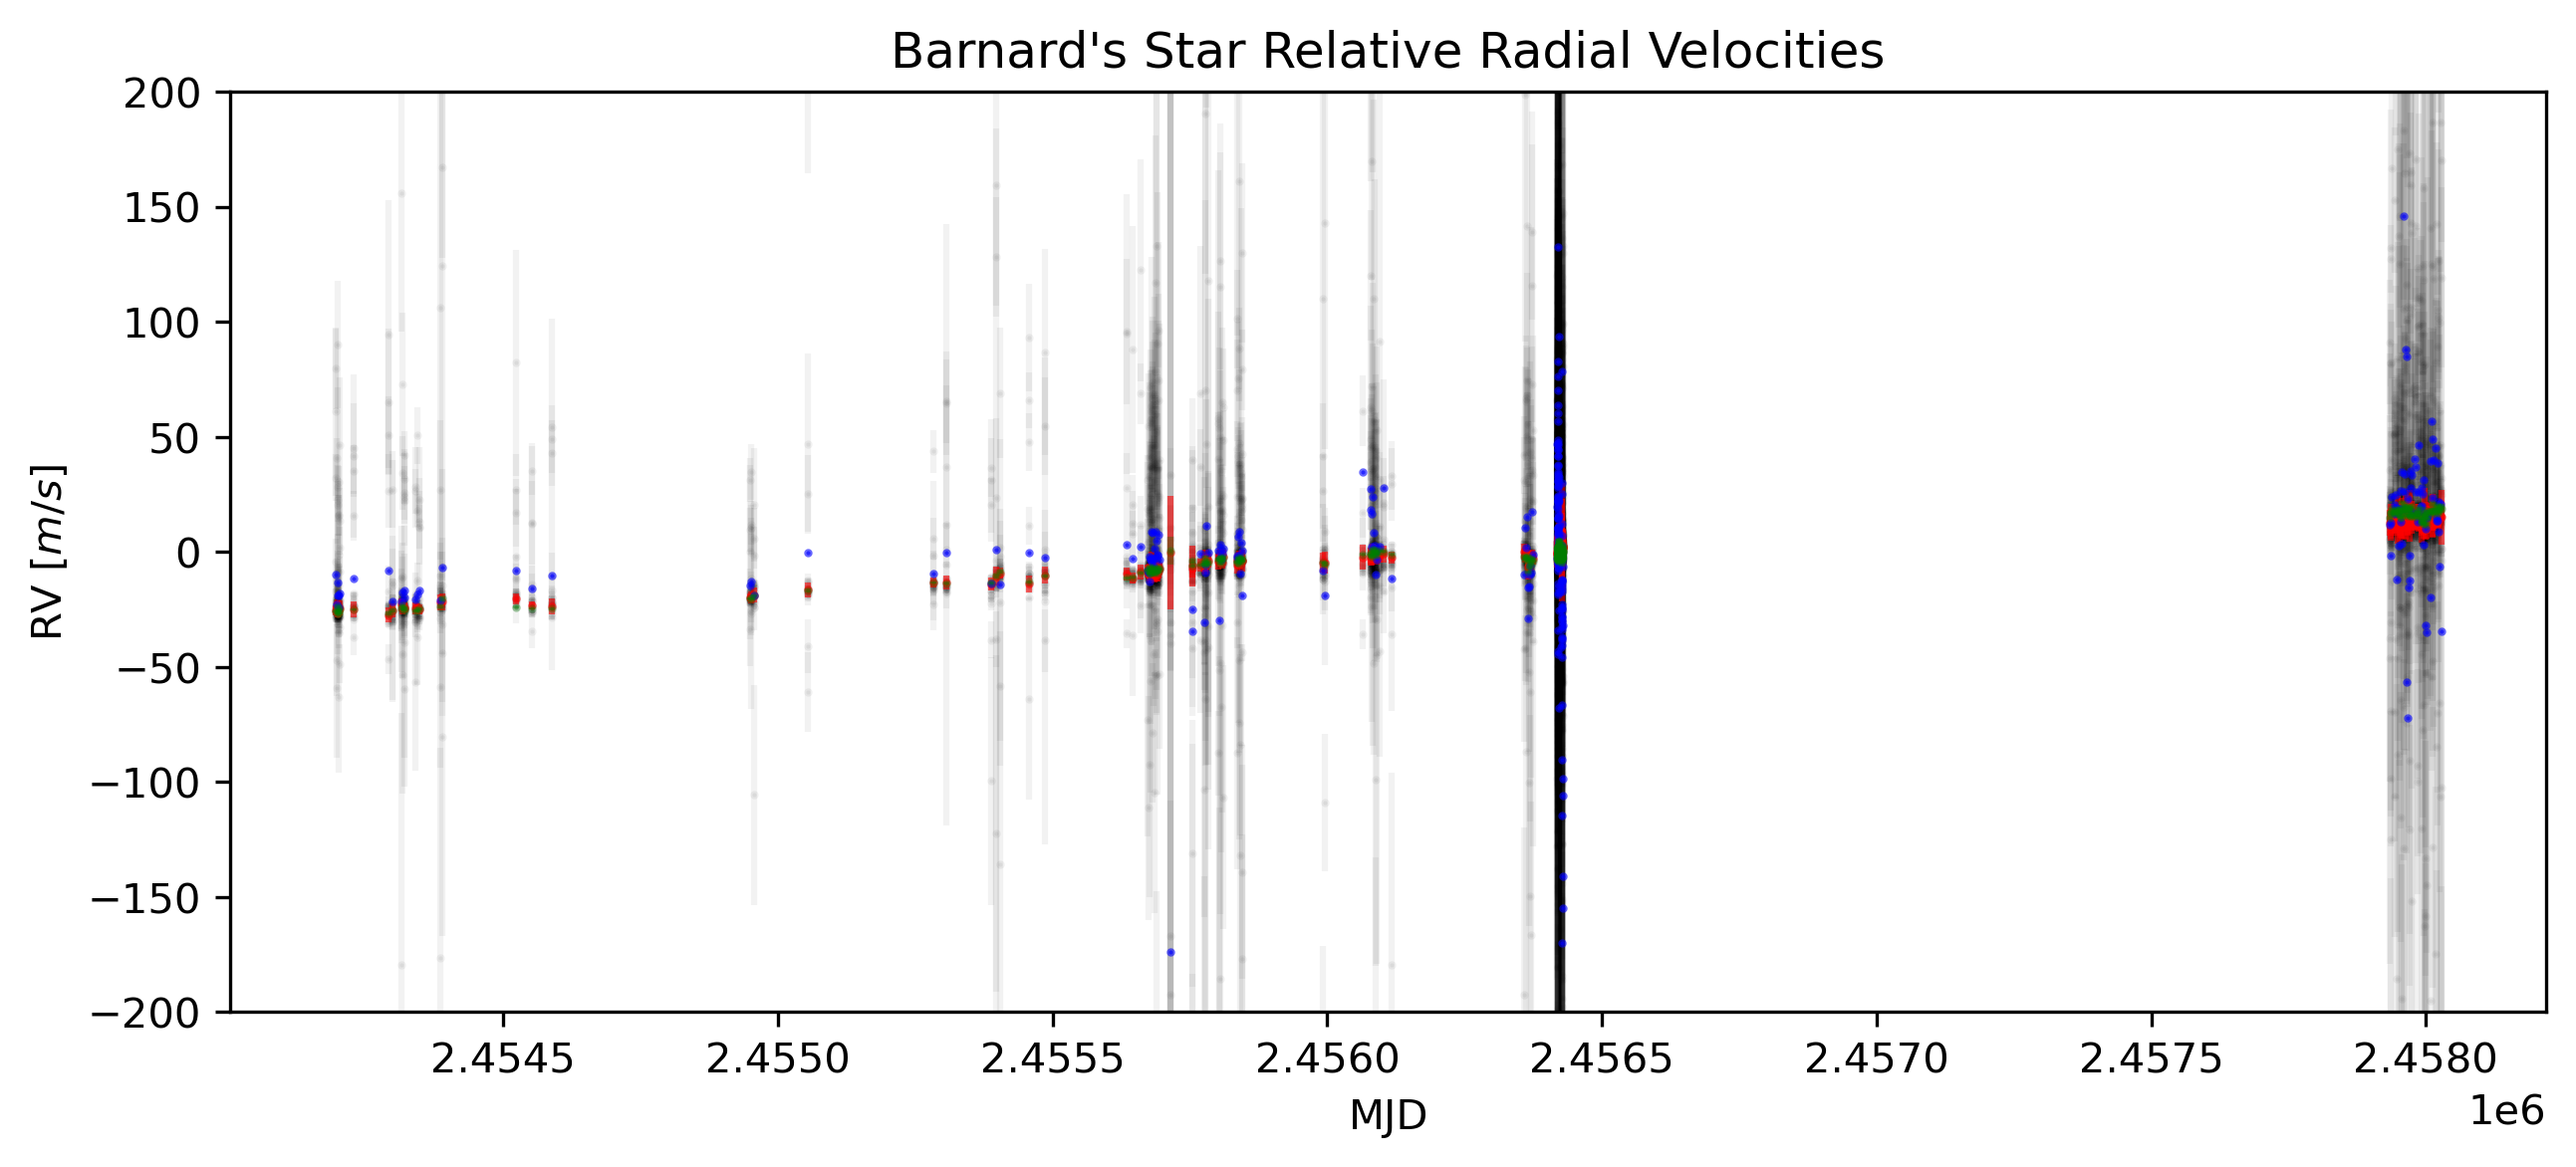

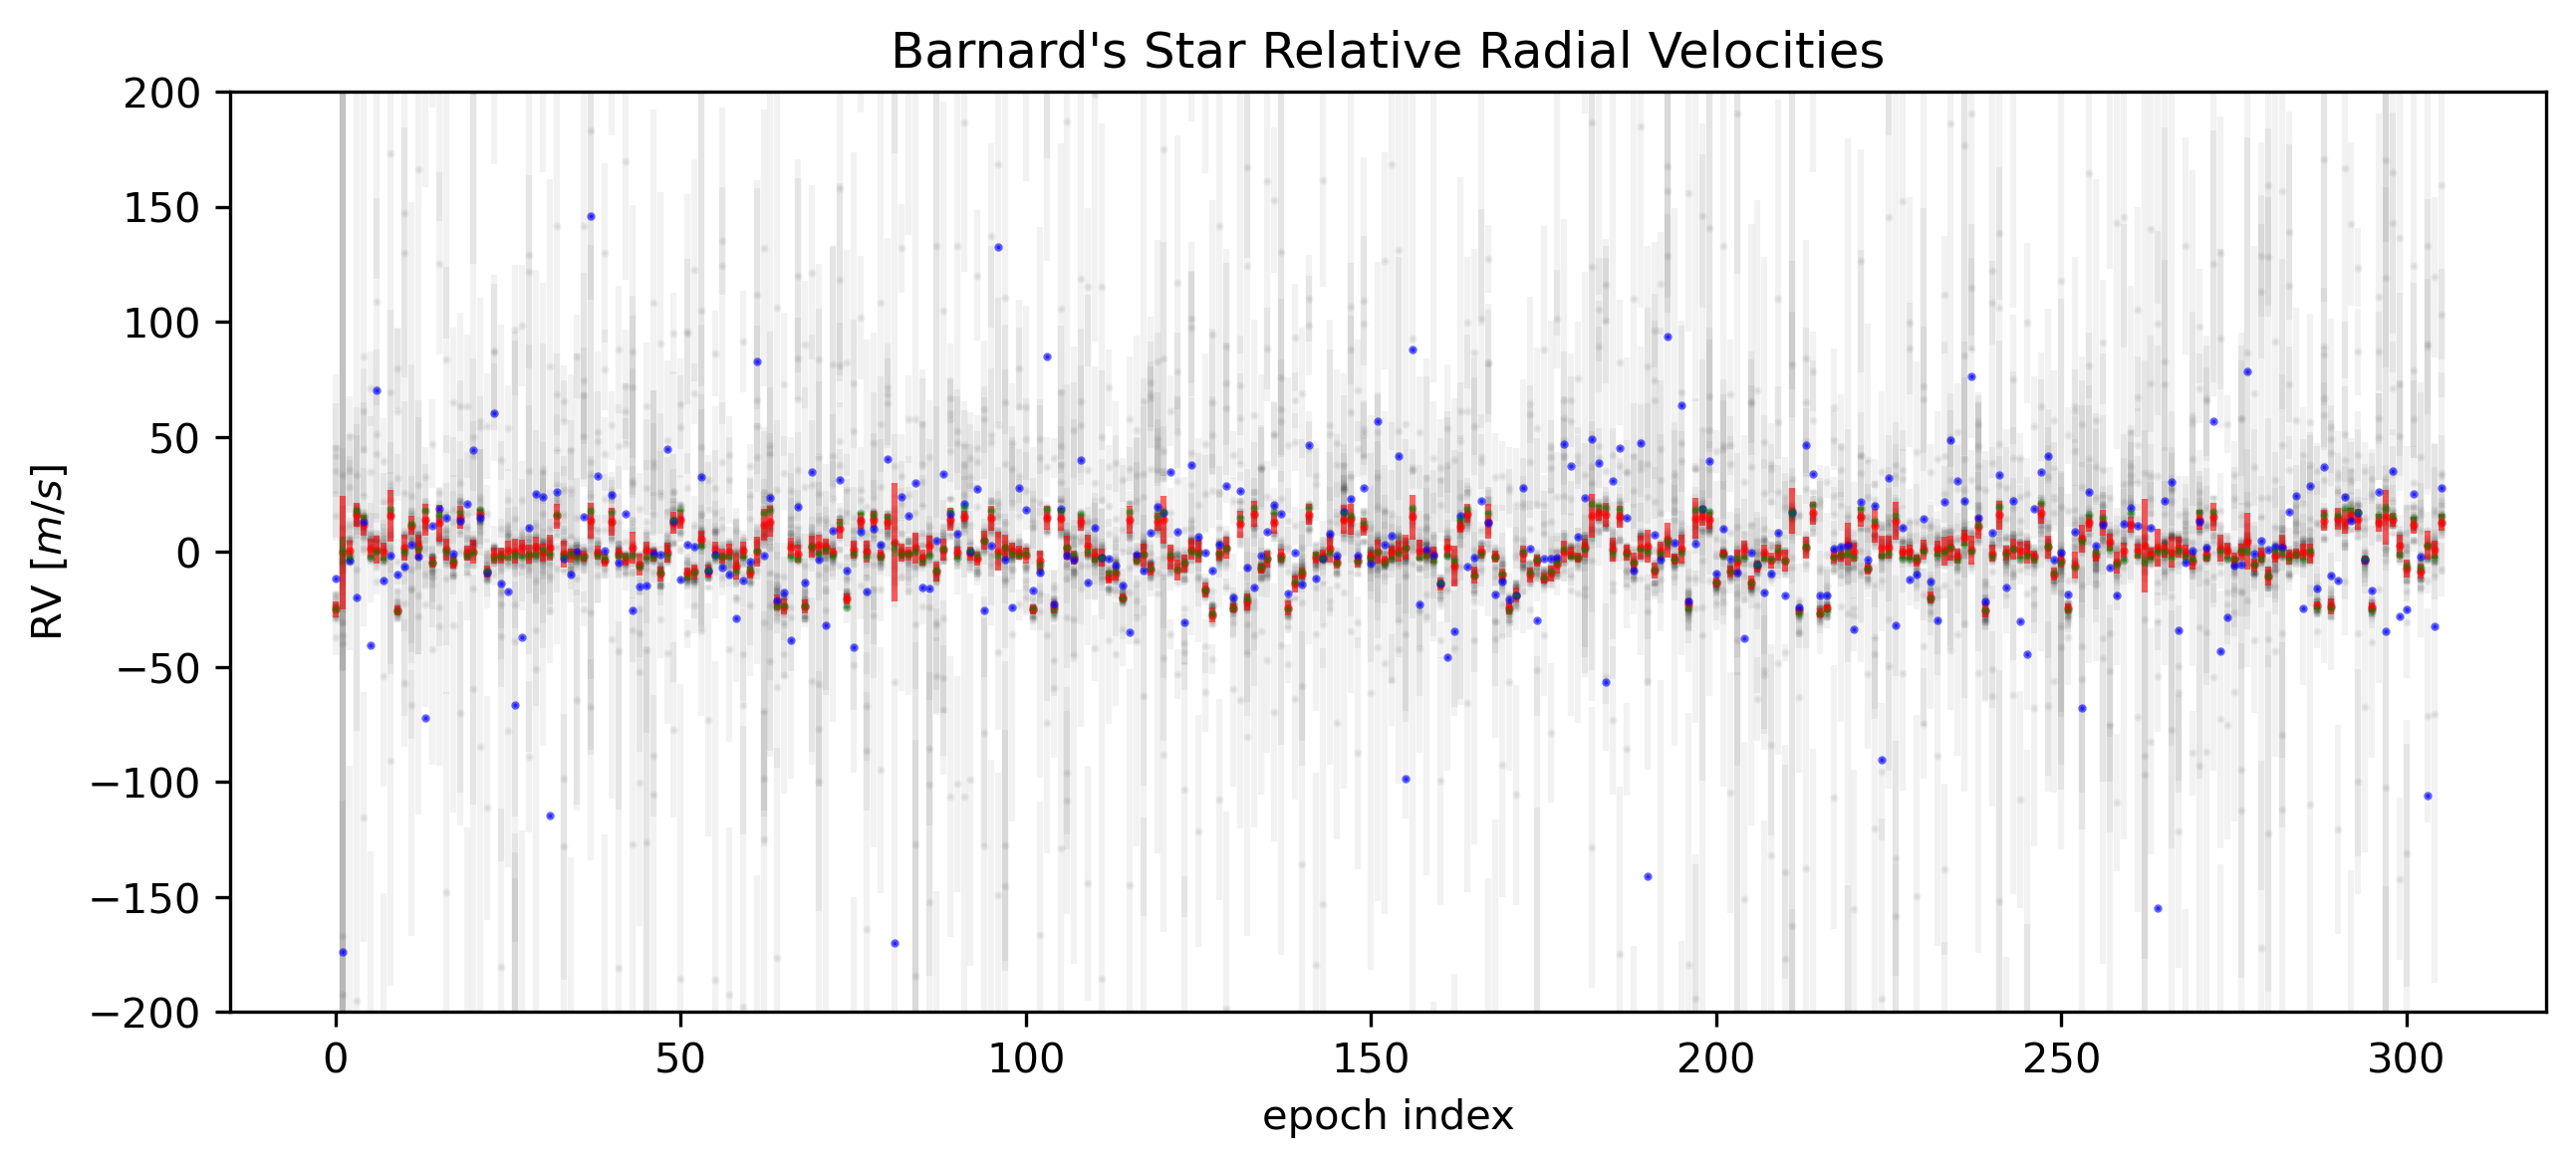

(306,) (18, 306)


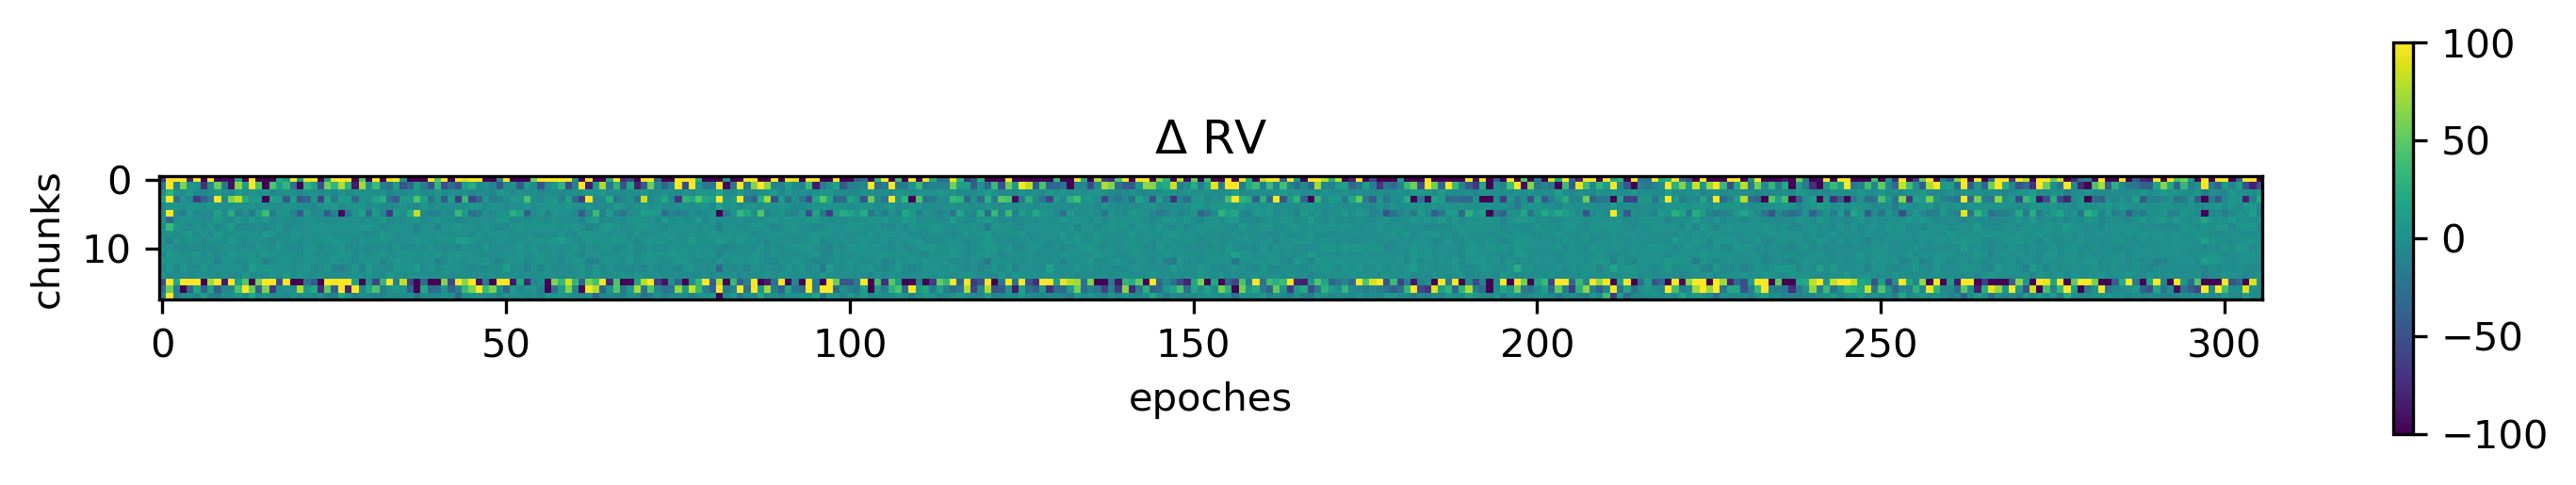

(18, 306)


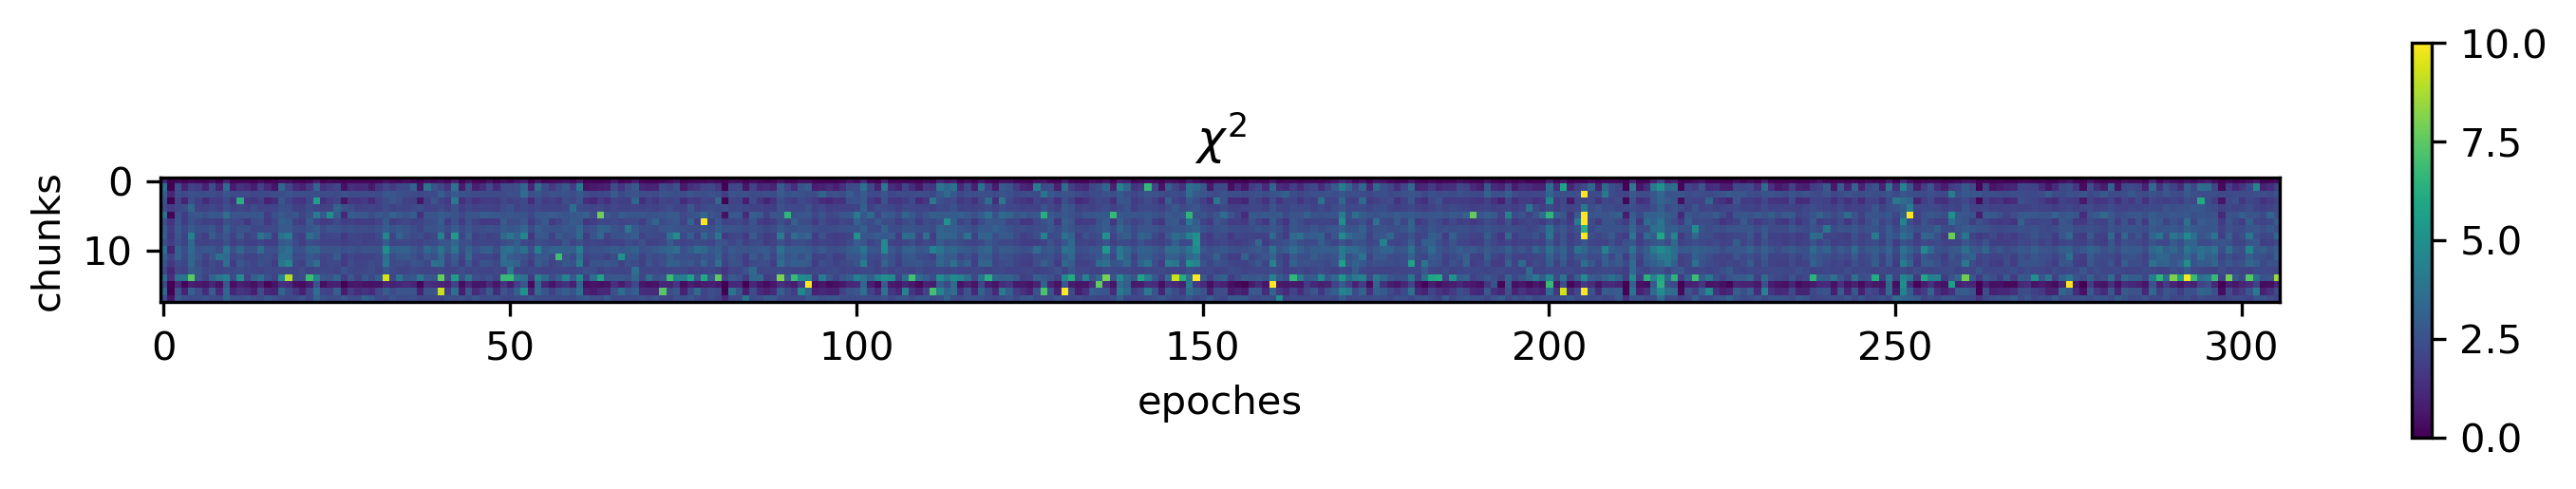

In [100]:
rv_all_order_plot(np.array(file_b['dates']),np.array(jabble_file['RV']),np.array(jabble_file['RV_err']),\
                  np.array(jabble_file['RV_comb']),np.array(jabble_file['RV_comb_err']),\
                  np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
                  np.array(file_b['bervs']),period=1e10)
rv_all_order_harps_plot(np.array(file_b['dates']),np.array(jabble_file['RV']),np.array(jabble_file['RV_err']),\
                        np.array(jabble_file['RV_comb']),np.array(jabble_file['RV_comb_err']),\
                        np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
                        np.array(file_b['bervs']),np.array(jabble_file['loss']))

In [54]:
import nifty_ls

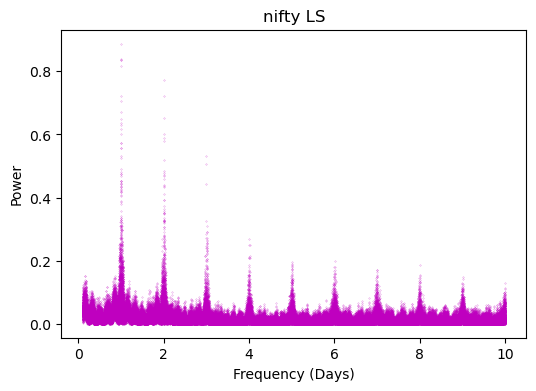

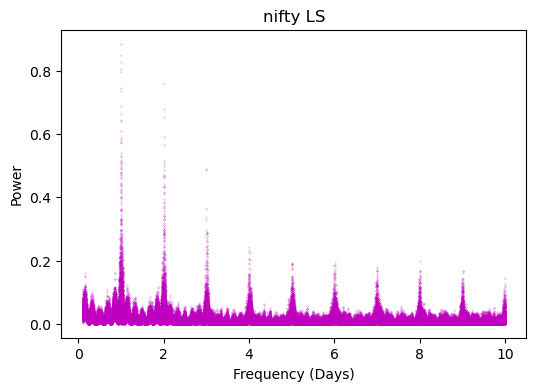

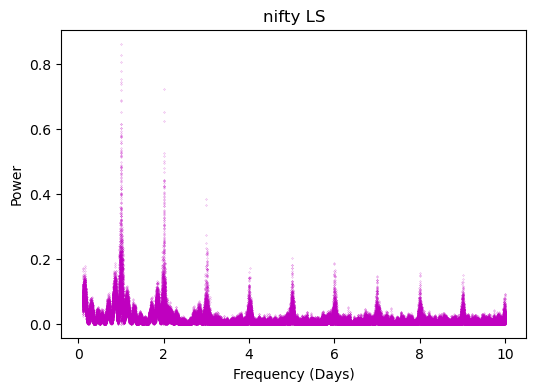

In [83]:
def nifty_ls_diagram(dates,rvs,error):
    nifty_res = nifty_ls.lombscargle(dates, rvs, dy=error, fmin=0.1, fmax=10)
    plt.figure(figsize=(6,4))
    plt.plot(nifty_res.freq(),nifty_res.power,'.m',markersize=0.4,alpha=0.7)
    plt.xlabel('Frequency (Days)')
    plt.ylabel('Power')
    plt.title('nifty LS')
    plt.show()

# print(np.array(file_b['dates']).shape,np.array(jabble_file['RV']).shape,np.array(jabble_file['RV_err']).shape)
# print(np.array(file_b['dates']).shape,np.array(jabble_file['RV_comb']).shape,np.array(jabble_file['RV_comb_err']).shape)
nifty_ls_diagram(np.array(file_b['dates']),np.array(jabble_file['RV_comb']),np.array(jabble_file['RV_comb_err']))
nifty_ls_diagram(np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']))
nifty_ls_diagram(np.array(file_b['dates']),np.array(file_b['bervs']),None)

In [48]:
all_models[-1].results

[{'out': {'grad': array([0., 0., 0., ..., 0., 0., 0.]),
   'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
   'funcalls': 341,
   'nit': 330,
   'warnflag': 0},
  'value': 12026646.871992368,
  'loss': '1.0 {self__class__.__name__}()'},
 {'out': {'grad': array([-4.91569174e+05,  1.38911257e+05,  1.43353429e+04,  6.64931908e+05,
           1.09228547e+04,  1.03271348e+05, -1.37121465e+05,  4.08152858e+03,
           3.27174868e+06,  2.58803390e+06,  1.68429055e+05,  8.76314194e+04,
           8.41702174e+05,  4.51097151e+05,  9.54085775e+03,  7.67423214e+05,
          -2.13277214e+05, -1.81606584e+03,  2.61011807e+04,  1.19494987e+04,
           2.62534734e+04, -2.96145622e+03, -5.00985627e+03,  3.97409652e+05,
           1.90593396e+05, -1.82904351e+03,  4.49010095e+05, -2.17225111e+04,
           1.30791921e+06, -4.97475429e+05,  3.22902510e+05,  1.95570975e+05,
           3.37649962e+04,  1.77949673e+04, -4.88252250e+02,  2.59863697e+03,
          -6.13907719e+03, -6.52633

In [ ]:
import nifty_ls
from astropy.timeseries import LombScargle
frequency, power = LombScargle(np.array(file_b['dates']), jabble_file['RV_comb']).autopower(method="fastnifty")

In [145]:
def plot_earth_residual_img(model,dataset,lrange,orders,rest_shifts,residual_resolution,plt_name,line_list,device):
    xrange = np.log(lrange)
    xmin, xmax = np.min(xrange), np.max(xrange)
    # xinds = ((dataset[0].xs[:] < xmax) * (dataset[0].xs[:] > xmin)).astype(bool)
    residual_img = np.zeros((len(dataset),residual_resolution))
    fig, ax = plt.subplots(2,2,figsize=(8, 8),height_ratios=[1,4],width_ratios=[4,1],sharex='col',sharey='row')
    fig.tight_layout()

    data, meta, keys = dataset.blockify(device,return_keys=True)

    max_shift, min_shift = np.max(rest_shifts), np.min(rest_shifts)
    new_grid = np.linspace(xmin,xmax,residual_resolution)

    epsilon = np.log(np.mean(lrange) + 1) - np.log(np.mean(lrange))
    model.fix()
    model.display()

    # print(np.sum(np.log(line_list[1].data["Wave"]) > xmin),np.sum(np.log(line_list[1].data["Wave"]) < xmax),\
    #      np.sum((np.log(line_list[1].data["Wave"]) > xmin)*(np.log(line_list[1].data["Wave"]) < xmax)))
    # for line in line_list[1].data[(np.log(line_list[1].data["Wave"]) > xmin) * (np.log(line_list[1].data["Wave"]) < xmax)]:
    #     print(line["Species"])
    #     ax[1,0].vlines(np.log(line["Wave"]),0,len(dataset))
    # for line in list_list
    for i,plt_epoch in enumerate(range(len(dataset))):
        datarow = jabble.loss.dict_ele(data,plt_epoch,device)
        metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
        
        xless = (dataset[plt_epoch].xs[:] <= (xmax + epsilon))
        xmore = (dataset[plt_epoch].xs[:] >= (xmin - epsilon)) #+ rest_shifts[plt_epoch] 
        xinds = (xless * \
                 xmore).astype(bool)
        # print(np.sum(xmore),np.sum(xless))
        x_grid = dataset[plt_epoch].xs[(~dataset[plt_epoch].mask)*xinds]
        y_grid = dataset[plt_epoch].ys[(~dataset[plt_epoch].mask)*xinds]
        residual = (y_grid - model([],x_grid,metarow))#*jnp.sqrt(dataset[plt_epoch].yivar[(~dataset[plt_epoch].mask)*xinds])

        if np.sum(xless) == 0:
            x_grid = np.array([dataset[plt_epoch].xs[~dataset[plt_epoch].mask].min()])
            residual = np.array([0.0])
        if np.sum(xmore) == 0:
            x_grid = np.array([dataset[plt_epoch].xs[~dataset[plt_epoch].mask].max()])
            residual = np.array([0.0])
        # print(residual.shape,np.sum(dataset[plt_epoch].mask*xinds),np.sum(xinds),np.sum(dataset[plt_epoch].mask))
        residual_img[i,:] = scipy.interpolate.interp1d(x_grid,residual,kind='nearest',bounds_error=False,fill_value=0.0)(new_grid )#+ \rest_shifts[plt_epoch]
    cmap = plt.get_cmap("RdBu")

    ax[0,1].axis('off')
    ax[0,0].step(new_grid,       (residual_img**2).sum(axis=0),'k',where='mid',zorder=1,alpha=0.3,ms=3)
    ax[0,0].step(new_grid,       (residual_img).sum(axis=0),'m',where='mid',zorder=1,alpha=0.3,ms=3)
    ax[1,1].step((residual_img**2).sum(axis=1),np.arange(len(dataset))[::-1],'k',where='post',zorder=1,alpha=0.3,ms=3)
    
    
    # ax[1,0].set_ylim(0,np.max(orders)+1)
    ax[1,0].set_xlim(xmin,xmax)
    extent = [xmin,xmax,0,len(dataset)+1]
    ax[1,0].imshow(residual_img,cmap=cmap,aspect="auto",vmin=-.1,vmax=.1,extent=extent,interpolation='nearest')
    ax[1,0].set_xlabel('Wavelength [$\AA$]')
    ax[1,0].set_ylabel('Chunks')
    # # plt.xticks([])
    ax[1,0].set_xticks(xrange)
    ax[1,0].set_xticklabels(['{:0.1f}'.format(l) for l in lrange])
    # ax[1,0].get_shared_x_axes().join(ax[1,0], ax[1,1])
    # plt.xlabel()
    # plt.savefig(os.path.join(out_dir, plt_name))
    plt.show()


    # worst_epochs = np.zeros(len(orders),dtype=bool)
    # worst_epochs = (residual_img**2).sum(axis=1) > 0.7
    # print(worst_epochs)
    # print(orders)
    # print(orders[worst_epochs])
    # return orders[worst_epochs]

[16 17 18 19]
(306,)
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-EpochShiftingModel------------------------------------------0
  0  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture_vmap---------------------------------------------------0
  1  2-StretchingModel---------------------------------------------0


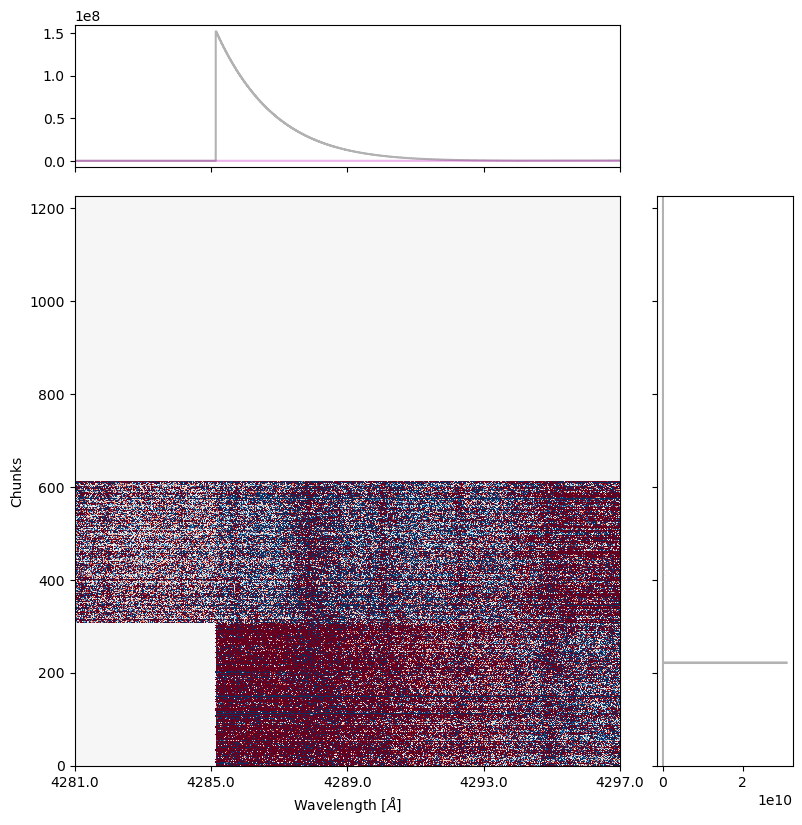

-AdditiveModel-------------------------------------------------17820
  0-CompositeModel----------------------------------------------7839
  0  0-EpochShiftingModel----------------------------------------306
  0  1-CardinalSplineMixture_vmap------------------------------------------------7533
  1-CompositeModel----------------------------------------------9981
  1  0-ShiftingModel--------------------------------------------1224
  1  1-CardinalSplineMixture_vmap------------------------------------------------7533
  1  2-StretchingModel------------------------------------------1224


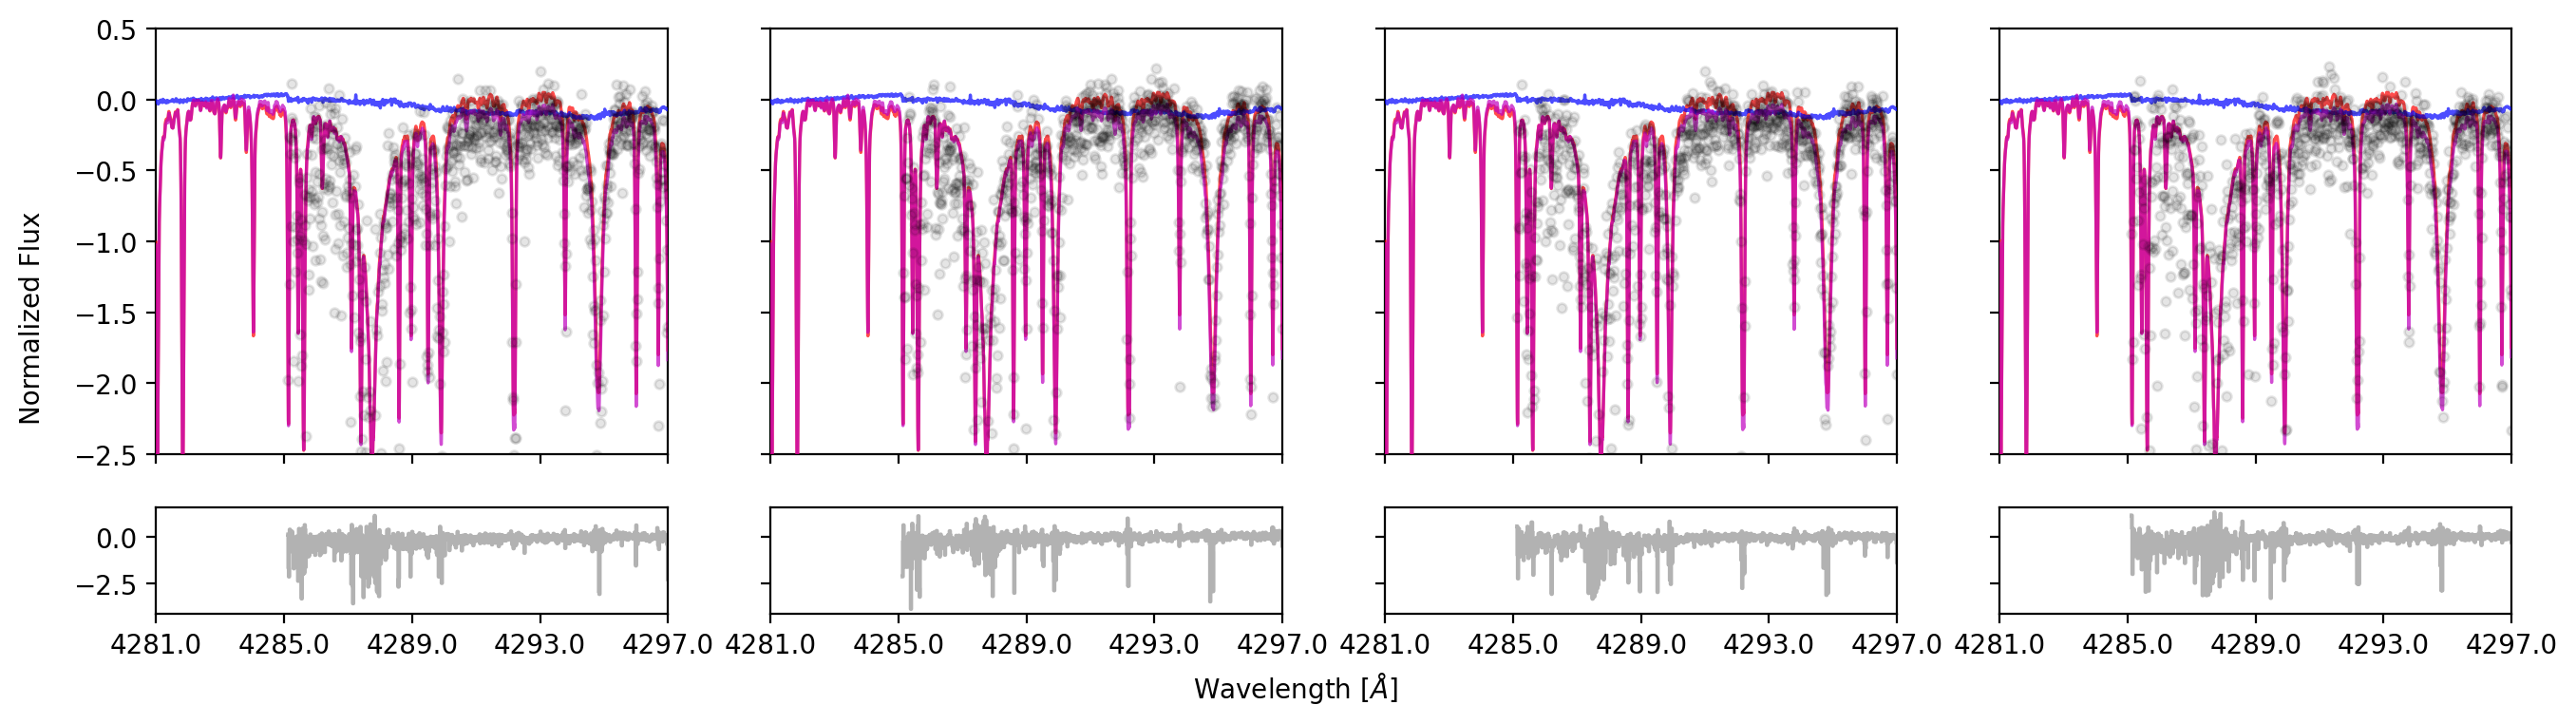

In [162]:
model_index = 3
# rv_data = jabble.physics.velocities(all_models[jjj][0][0].p)
orders = np.unique(all_models[model_index].metadata['orders'])
print(orders)
order_index = 2

dataset, _, _, _, _ = get_dataset(file_b,orders,cpus[0])
ls_means = np.exp(file_b['xs'][orders].mean(axis=1).mean(axis=1))[order_index]
lrange = np.ceil(ls_means) + np.arange(0.0,20.0,4.0)

data, meta = dataset.blockify(cpus[0])
rest_shifts = all_models[model_index][0][0].p
index_sort = np.argsort(rest_shifts)
plot_earth_residual_img(all_models[model_index],dataset,lrange,index_sort,rest_shifts,residual_resolution,"",None,device=cpus[0])

rv_inds = [0,1,2,3]
lrange_stack = np.ones(len(rv_inds))[:,None] * lrange[None,:]
make_order_plot(dataset,all_models[model_index],lrange_stack,[orders[order_index+1]],rv_inds,cpus[0])

In [93]:
lmin = 5580
lmax = 5585
lspacing = 1
residual_resolution = 2048
lrange = np.arange(lmin,lmax+lspacing,lspacing)
plt_name =  "02-{}_res_img_starref.png".format(os.path.split(model_name_b)[-1],np.min(orders),np.max(orders))

rest_vel = model_b[0][0].p#np.zeros(.shape)
index_sort = np.argsort(rest_vel)
rest_shifts =  model_b[0][0].p#jabble.physics.shifts(rest_vel)


NameError: name 'model_name_b' is not defined

In [ ]:
for filename in dir:
    model = jabble.model.load(filename)
    rv_data = jabble.physics.velocities(model[0][0].p)
    orders = np.unique(model.metadata['orders'])
    lmean = np.mean(np.exp(model[0][1].xs))
    lmin = lmean-10
    lmax = lmean+10
    lspace = 4
    
    lrange = np.arange(lmin,lmax+lspace,lspace)
    
    rv_inds = [-1,0,1]
    make_order_plot(file_b,model,lmin,lmax,lrange,[orders[1]],rv_inds,cpus[0])

In [ ]:
def imshow_rv_difference(all_models,times_t,times_e,rv_e,err_e,bervs,):
    
    rv_array = np.zeros((len(all_models),*all_models[0][0][0].p.shape))
    order_array = []

    info_e = 1/err_e**2
    epoches_span_e = np.zeros(len(rv_e))

    rv_comb = jnp.array(len(times_t))
    for iii,time in enumerate(times_t):
        indices = times_e == time

        rv_indiv[indices] = rv_e[indices] + bervs[iii] - correct_vel[iii]
        epoches_span_e[indices] = iii
        rv_comb = rv_comb.at[iii].set(jnp.dot(info_e[indices],rv_e[indices])/jnp.sum(info_e[indices]))
        info_comb = info_comb.at[iii].set((jnp.dot(info_e[indices],rv_e[indices]**2)/jnp.sum(info_e[indices])) - rv_comb[iii]**2)


    for i,model in enumerate(all_models):
        # data, _, _, full_init_shifts, _ = get_dataset(file_b,orders,cpus[0])
        datablock, metablock, keys = data.blockify(cpus[0],return_keys=True)
        rv_array[i,:] = jabble.physics.velocities(model[0][0].p)
        order_array.append(np.unique(model.metadata['orders']))



In [ ]:
imshow_rv_difference(all_models)

5577 night sky line

In [ ]:
# modelname = 'barnardsvmapmodel1.mdl'
# # model = jabble.model.load(modelname)
# jabble.model.save(modelname,model)

In [ ]:
# def make_plot(model,dataset,init_shifts,filename):
#     x_window = np.log(4550) - np.log(4549)
#     lmin = np.exp(dataset.xs[0,500])
#     lmax = np.exp(dataset.xs[0,1500])
#     lrange = np.arange(lmin,lmax,5)
#     plt_unit = u.Angstrom
#     epoches = 25
#     r_plots = 5

#     vel_epoch = 5
#     fig, axes = plt.subplots(
#         epoches // r_plots,
#         r_plots,
#         figsize=(8, 8),
#         sharex=False,
#         sharey=True,
#         facecolor=(1, 1, 1),
#         dpi=200,
#     )
#     # fig.suptitle(filenames[model_num])
#     for plt_epoch in range((epoches // r_plots) * r_plots):
#         xplot = np.linspace(np.log(lmin), np.log(lmax), dataset.xs.shape[1] * 10)
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(
#             xplot.min() + model[0][0].p[plt_epoch],
#             xplot.max() + model[0][0].p[plt_epoch],
#         )

#         # model_set[model_num].fix()
#         # model_set[model_num].fit(0)
#         # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
#         # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])

#         model.fix()

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(
#             dataset.xs[plt_epoch, :],
#             dataset.ys[plt_epoch, :],
#             dataset.yerr[plt_epoch, :],
#             fmt=".k",
#             elinewidth=1.2,
#             zorder=1,
#             alpha=0.5,
#             ms=3,
#         )

#         # true_model.fix()

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(
#             xplot,
#             model([], xplot, plt_epoch),
#             "-r",
#             linewidth=1.2,
#             zorder=2,
#             alpha=0.5,
#             ms=6,
#         )
#         # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2, 1)
#         #         axes[i,j].set_yticks([])
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(
#             ["{:2.0f}".format(x) for x in lrange]
#         )

#         res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#         residual = loss(
#             model.get_parameters(),
#             dataset,
#             plt_epoch,
#             model,
#         )
#         res_ax.step(
#             dataset.xs[plt_epoch, :], residual, where="mid", alpha=0.3, label="residual"
#         )
#         res_ax.set_ylim(0.0, 20)
#         res_ax.set_yticks([])
#         # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#         #             model_set[i][j].results[-2]['grad'][:],\
#         #             where='mid',alpha=0.4,label='residual',zorder=-1)
#         # res_ax.set_yticks([])

#         # res_ax.step(x_grid,\
#         #             rv_model_deriv[:,plt_epoch],\
#         #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

#         #     res_ax.step(x_grid,\
#         #                 rv_loss_deriv[:,plt_epoch],\
#         #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

#         #     align_yaxis(, 0, , 0)

#         align.yaxes(
#             axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2.0 / 3.0
#         )

#     # res.get_shared_y_axes().join(ax1, ax3)
#     fig.text(0.5, 0.04, "$\lambda$", ha="center")
#     fig.text(0.04, 0.5, "y", va="center", rotation="vertical")
#     # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
#     # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
#     fig.text(0.96, 0.5, "residuals", va="center", rotation=270)

#     plt.savefig(
#         os.path.join(out_dir, "02-res_{}.png".format(filename)),
#         dpi=300,
#         bbox_inches="tight",
#     )
#     plt.show()

6563 h alpha

In [ ]:
filenames = ['51peg','barnards']
make_plot(model_b,dataset_b,shifts_b,filenames[1])

In [ ]:
# def make_better_plot(model_set,datasets,file_set):
    

#     fig, axes = plt.subplots(2*len(model_set),4,figsize=(4*4,4*len(model_set)),sharex=True,facecolor=(1, 1, 1),dpi=200,height_ratios=[4,1]*len(model_set))
    
#     for jj,(model,dataset,file) in enumerate(zip(model_set,datasets,file_set)):
#         x_window = np.log(4550) - np.log(4549)
#         lmin = np.exp(dataset.xs[0,0])
#         lmax = np.exp(dataset.xs[0,2000])
#         lrange = np.arange(lmin,lmax,5)
#         sort_airmasses = np.argsort(np.array(file['airms'][:]))
#         plt_epochs = np.concatenate((sort_airmasses[:2],sort_airmasses[-2:]))
        
        
        
        
#         offset = 1.0
#         xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs.shape[1]*10)
#         for ii,plt_epoch in enumerate(plt_epochs):
#             axes[2*jj,ii].set_xlim(xplot.min()+model[0][0].p[plt_epoch],xplot.max()+model[0][0].p[plt_epoch])
            
#             model.fix()
            
#             axes[2*jj,ii].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
#                                      dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
            
#             axes[2*jj,ii].plot(xplot,offset + model[0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             axes[2*jj,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             axes[2*jj,ii].plot(xplot,model[2]([],xplot,plt_epoch),'-m',linewidth=1.2,zorder=3,alpha=0.7,ms=6)
            
#             # axes[0,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             # axes[0,ii].plot(xplot,offset + model([],xplot,plt_epoch),'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
            
            
#             axes[2*jj,ii].set_ylim(-2,3)
#             axes[2*jj,ii].set_xticks([])
#             # axes[0].set_yticks([])
#             axes[2*jj+1,ii].set_xticks(np.log(lrange))
#             axes[2*jj+1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
            
#             axes[2*jj+1,ii].plot(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:] - model([],dataset.xs[plt_epoch,:],plt_epoch),'.k',alpha=0.4,ms=1)
            
#             axes[2*jj+1,ii].set_ylim(-0.1,0.1)
#             axes[2*jj,ii].set_title('airmass = {}'.format(file['airms'][:][plt_epoch]))
#         # res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#         # residual = loss(model_set[model_num].get_parameters(),dataset,plt_epoch,model_set[model_num])
#         # res_ax.step(dataset.xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
#         # res_ax.set_ylim(0.0,20)
#         # res_ax.set_yticks([])
#         # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#         #             model_set[i][j].results[-2]['grad'][:],\
#         #             where='mid',alpha=0.4,label='residual',zorder=-1)
#         # res_ax.set_yticks([])
        
#         # res_ax.step(x_grid,\
#         #             rv_model_deriv[:,plt_epoch],\
#         #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
#         #     res_ax.step(x_grid,\
#         #                 rv_loss_deriv[:,plt_epoch],\
#         #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
#         #     align_yaxis(, 0, , 0)
            
#             # align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)
        
#         # res.get_shared_y_axes().join(ax1, ax3)
#         fig.text(0.5, 0.04, '$\lambda$', ha='center')
#         # fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
#         # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
#         # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
#         # fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
#     # plt.savefig(os.path.join(out_dir,'02-full-barn-51peg.png'),dpi=300,bbox_inches='tight')
#     plt.show()

In [ ]:
# make_better_plot(model_set,datasets,file_set)

In [ ]:
# tell_loss = [[],[]]
# for jjj, (dataset, model) in enumerate(zip(datasets,model_set)):
#     for iii in range(dataset.ys.shape[0]):
#         tell_loss[jjj].append(loss([],dataset,iii,model[0]).sum())

# plt.plot(np.array(file_p['airms'][:]),tell_loss[0],'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),tell_loss[1],'.r',label='barnards')
# # plt.ylim(0.0,5e4)

# # plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# # plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
# plt.xlabel('airmass')
# plt.ylabel('$\Sigma_* (y_* - \hat{y}_s(x_*)) I_{y*}$')
# # plt.plot()
# plt.legend()
# # plt.savefig(os.path.join(out_dir,'02-airmass_loss.png'),dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
# plt.xlabel('airmass')
# plt.ylabel('~a')
# x_space = np.linspace(np.min(np.array(file_b['airms'][:])),np.max(np.array(file_b['airms'][:])))
# plt.plot(x_space,x_space,'-.k',alpha=0.3)
# plt.legend()
# # plt.savefig(os.path.join(out_dir,'02-airmass_an.png'),dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(1,figsize=(4,4),sharex=True,facecolor=(1, 1, 1),dpi=200)

# plt_epoch = 10
# x_window = np.log(4550) - np.log(4549)
# lmin = np.exp(dataset_p.xs[0,500])
# lmax = np.exp(dataset_p.xs[0,1500])
# lrange = np.arange(lmin,lmax,5)
# xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset_p.xs.shape[1]*10)
# axes.plot(xplot,model_p[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='51 peg')
# axes.plot(xplot,0.05 + model_b[1]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='barnard')
# axes.legend()

# axes.set_ylim(-0.2,0.1)
# axes.set_xticks([])
# axes.set_ylabel('log flux + offset')
# axes.set_xlabel('$\lambda$')
# axes.set_xticks(np.log(lrange))
# axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
# plt.title('just tellurics')
# # plt.savefig(os.path.join(out_dir,'02-airmass-tell.png'),dpi=300,bbox_inches='tight')
# plt.show()